In [1]:
import numpy as np
import pandas as pd
import math
import itertools as itt
import collections as clc
from matplotlib import pyplot as plt

from utils import *

path_data = '/Users/dariozappala/Library/CloudStorage/Dropbox/università/RTD-A/progetti/dati/Crunchbase/'
path_images = './immagini/'

# Lettura

In [2]:
%%time
df_organizations = pd.read_csv(path_data + 'organizations.csv')
clean_organizations(df_organizations)

# Select companies with declared market sectors and founded on 1970 or later
rows_sel = (~df_organizations['category_list'].isna()) & (df_organizations['founded_on'] > '1970-01-01')
print(f'Selected organizations: {rows_sel.sum()} among {rows_sel.shape[0]}.')

df_organizations = (
    df_organizations
    .loc[rows_sel, ['founded_on', 'name', 'country_code', 'city', 'category_list']]
    .sort_values(['founded_on', 'name'])
    .reset_index(drop = True)
)

# Transform market sectors from one big string to a list of strings
df_organizations['category_list'] = df_organizations['category_list'].str.split(',')

df_organizations

Selected organizations: 2159883 among 3090736.
CPU times: user 31.3 s, sys: 5.29 s, total: 36.6 s
Wall time: 38 s


,founded_on,name,country_code,city,category_list
0,1970-01-02,Danco Transmission & Auto Care,USA,Fairfield,[Health Care]
1,1970-01-02,Derek Brown's Academy of Driving,CAN,Calgary,[Education]
2,1970-01-02,Devika Group,IND,New Delhi,"[Real Estate, Real Estate Investment, Service ..."
3,1970-01-02,Kenworth de Monterrey,MEX,Apodaca,"[Automotive, Transportation]"
4,1970-01-02,Mendocino Coast Clinics,USA,Fort Bragg,"[Communities, Health Care, Medical, Non Profit]"
...,...,...,...,...,...
2159878,2023-09-05,Gigma,USA,San Francisco,[Internet]
2159879,2023-09-06,Easy pay dz,DZA,Aokas,"[Banking, Payments, Social Shopping]"
2159880,2023-09-06,The Open Network Foundation,CHE,Zug,"[Blockchain, Payments]"
2159881,2023-09-08,Write It Right content writing services in dubai,ARE,Dubai,[Content Marketing]


# Settori di mercato

In [3]:
ser_specific_sectors_n = pd.Series(df_organizations['category_list'], name = 'sector').explode().dropna().value_counts().sort_index()
n_sectors = ser_specific_sectors_n.shape[0]
dict_sector_to_i = {ser_specific_sectors_n.index[i]: i for i in range(n_sectors)}

print(f'N. of specific sectors: {n_sectors}\n')
display(ser_specific_sectors_n.sort_values(ascending = False))

N. of specific sectors: 743



sector
Software                  281558
Information Technology    257105
Consulting                230034
Manufacturing             207698
Health Care               184312
                           ...  
Darknet                        7
Roku                           7
Generation Y                   7
RISC                           6
Ultimate Frisbee               4
Name: count, Length: 743, dtype: int64

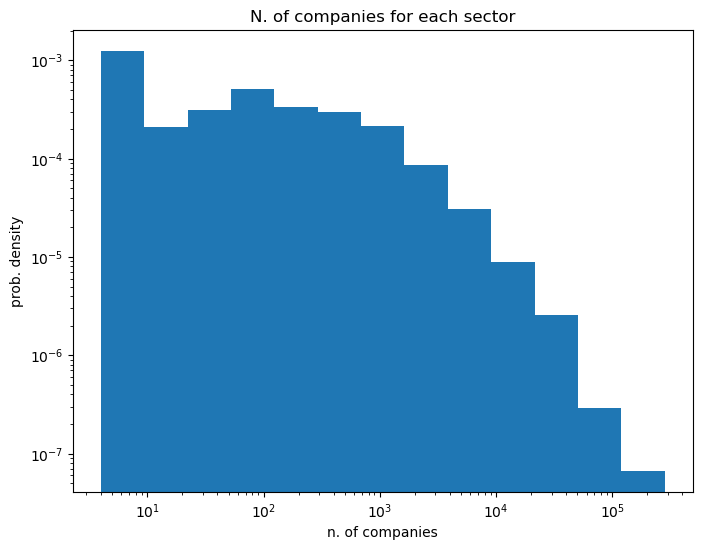

In [42]:
n_bins = math.floor(1/2 * pow(ser_specific_sectors_n.shape[0], 1/2))
bins = np.logspace(np.log10(ser_specific_sectors_n.min()), np.log10(ser_specific_sectors_n.max()), n_bins + 1)

fig, ax = plt.subplots(figsize = (8, 6))
ax.hist(ser_specific_sectors_n, bins = bins, density = True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('n. of companies')
ax.set_ylabel('prob. density')
ax.set_title('N. of companies for each sector')
plt.show()

# Evoluzione e rete

In [5]:
# Build 'sectors' with numeric values instead of strings
df_organizations['sectors'] = df_organizations['category_list'].apply(lambda x: list(map(dict_sector_to_i.get, x)))
df_organizations.drop(columns = 'category_list', inplace = True)

# Build 'links' column as a combination of all pairs from 'sectors'
df_organizations['links'] = df_organizations['sectors'].apply(lambda x: list(itt.combinations(x, 2)))

# Change 'founded_on' to the first day of the month
df_organizations['founded_on'] = df_organizations['founded_on'].dt.to_period('M').dt.to_timestamp()

df_organizations

,founded_on,name,country_code,city,sectors,links
0,1970-01-01,Danco Transmission & Auto Care,USA,Fairfield,[320],[]
1,1970-01-01,Derek Brown's Academy of Driving,CAN,Calgary,[213],[]
2,1970-01-01,Devika Group,IND,New Delhi,"[551, 552, 599]","[(551, 552), (551, 599), (552, 599)]"
3,1970-01-01,Kenworth de Monterrey,MEX,Apodaca,"[48, 675]","[(48, 675)]"
4,1970-01-01,Mendocino Coast Clinics,USA,Fort Bragg,"[124, 320, 425, 463]","[(124, 320), (124, 425), (124, 463), (320, 425..."
...,...,...,...,...,...,...
2159878,2023-09-01,Gigma,USA,San Francisco,[370],[]
2159879,2023-09-01,Easy pay dz,DZA,Aokas,"[54, 490, 630]","[(54, 490), (54, 630), (490, 630)]"
2159880,2023-09-01,The Open Network Foundation,CHE,Zug,"[68, 490]","[(68, 490)]"
2159881,2023-09-01,Write It Right content writing services in dubai,ARE,Dubai,[146],[]


In [6]:
df_month_foundation = df_organizations[['name']].groupby(df_organizations['founded_on'].dt.month).count()
df_month_foundation.rename(columns = {'name': 'count'}, inplace = True)
df_month_foundation.index.names = ['month_foundation']
df_month_foundation['fraction'] = df_month_foundation['count'] / df_month_foundation['count'].sum()
df_month_foundation

,count,fraction
month_foundation,,
1,1755255,0.812663
2,37592,0.017405
3,42240,0.019557
4,41994,0.019443
5,37821,0.017511
6,38820,0.017973
7,36029,0.016681
8,33827,0.015662
9,35854,0.016600


In [7]:
df_evolution = pd.merge(
    df_organizations[['founded_on', 'sectors']]\
        .explode('sectors').groupby(pd.Grouper(key = 'founded_on', freq = 'MS'))\
        .agg({'sectors': lambda x: clc.Counter(x)}),
    df_organizations.loc[df_organizations['links'].astype(bool), ['founded_on', 'links']]\
        .explode('links').groupby(pd.Grouper(key = 'founded_on', freq = 'MS'))\
        .agg({'links': lambda x: clc.Counter(x)}),
    left_index = True, right_index = True, how = 'outer'
)
n_times = df_evolution.shape[0]
df_evolution

,sectors,links
founded_on,,
1970-01-01,"{320: 3, 213: 3, 551: 2, 552: 1, 599: 3, 48: 1...","{(551, 552): 1, (551, 599): 1, (552, 599): 1, ..."
1970-02-01,"{249: 1, 250: 2, 387: 1, 405: 3, 551: 2, 358: ...","{(249, 250): 1, (249, 387): 1, (249, 405): 1, ..."
1970-03-01,"{549: 2, 675: 1, 676: 1, 132: 6, 176: 1, 655: ...","{(549, 675): 1, (549, 676): 1, (675, 676): 1, ..."
1970-04-01,"{535: 2, 551: 9, 12: 2, 419: 1, 520: 2, 721: 2...","{(535, 551): 2, (12, 419): 1, (12, 520): 1, (1..."
1970-05-01,"{405: 4, 675: 7, 712: 1, 77: 1, 238: 1, 310: 3...","{(405, 675): 3, (405, 712): 1, (675, 712): 1, ..."
...,...,...
2023-05-01,"{38: 75, 213: 13, 167: 7, 582: 54, 631: 150, 1...","{(167, 582): 2, (167, 631): 5, (582, 631): 26,..."
2023-06-01,"{268: 15, 370: 18, 531: 7, 631: 107, 672: 4, 4...","{(268, 370): 3, (268, 531): 1, (268, 631): 5, ..."
2023-07-01,"{167: 4, 194: 8, 419: 16, 320: 16, 631: 87, 38...","{(167, 194): 1, (167, 419): 2, (194, 419): 4, ..."


In [8]:
arr_nodes = np.zeros([n_times, n_sectors], dtype = np.uint32)
arr_adj = np.zeros([n_times, n_sectors, n_sectors], dtype = np.uint32)

# Build vector of nodes that evolves in time
# Build adjacency matrix that evolves in time
for t in range(n_times):
    if (t > 0):
        arr_nodes[t, ...] = arr_nodes[t - 1, ...]
        arr_adj[t, ...] = arr_adj[t - 1, ...]
    for node, value in df_evolution['sectors'][t].items():
        arr_nodes[t, node] += value
    for link, value in df_evolution['links'][t].items():
        arr_adj[t, link[0], link[1]] += value
        arr_adj[t, link[1], link[0]] += value

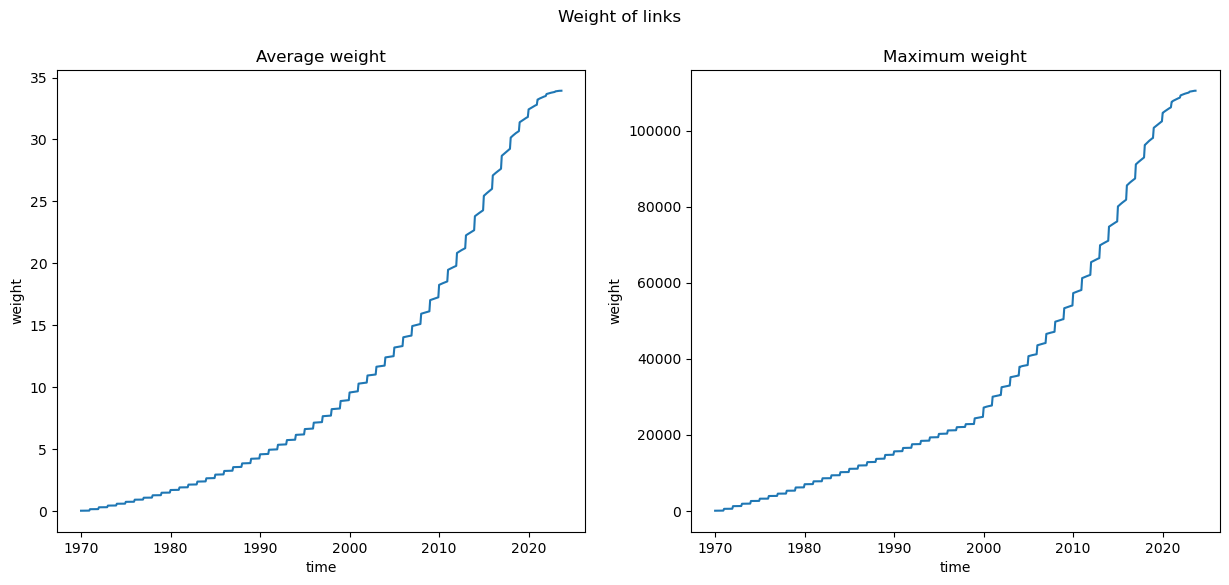

In [35]:
arr_avg_weight = arr_adj.sum(axis = (1, 2)) / (n_sectors * (n_sectors - 1))
arr_max_weight = arr_adj.max(axis = (1, 2))

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

ax = axes[0]
ax.plot(df_evolution.index, arr_avg_weight)
ax.set_xlabel('time')
ax.set_ylabel('weight')
ax.set_title('Average weight')

ax = axes[1]
ax.plot(df_evolution.index, arr_max_weight)
ax.set_xlabel('time')
ax.set_ylabel('weight')
ax.set_title('Maximum weight')

fig.suptitle('Weight of links')
plt.show()

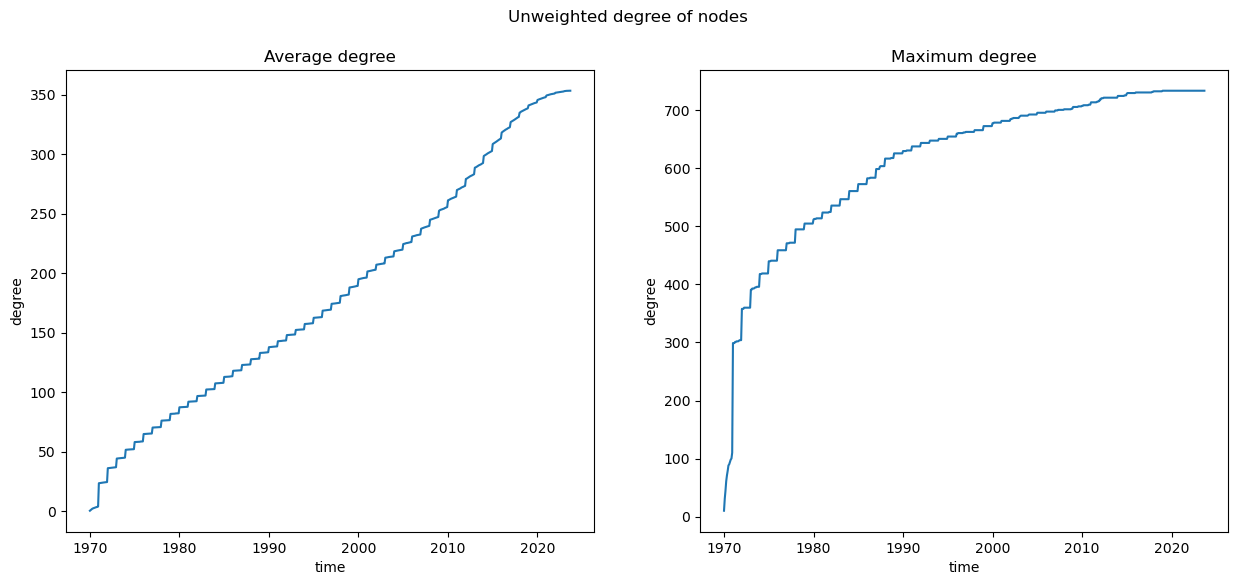

In [33]:
arr_avg_degree = arr_adj.astype(bool).sum(axis = 2).mean(axis = 1)
arr_max_degree = arr_adj.astype(bool).sum(axis = 2).max(axis = 1)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

ax = axes[0]
ax.plot(df_evolution.index, arr_avg_degree)
ax.set_xlabel('time')
ax.set_ylabel('degree')
ax.set_title('Average degree')

ax = axes[1]
ax.plot(df_evolution.index, arr_max_degree)
ax.set_xlabel('time')
ax.set_ylabel('degree')
ax.set_title('Maximum degree')

fig.suptitle('Unweighted degree of nodes')
plt.show()

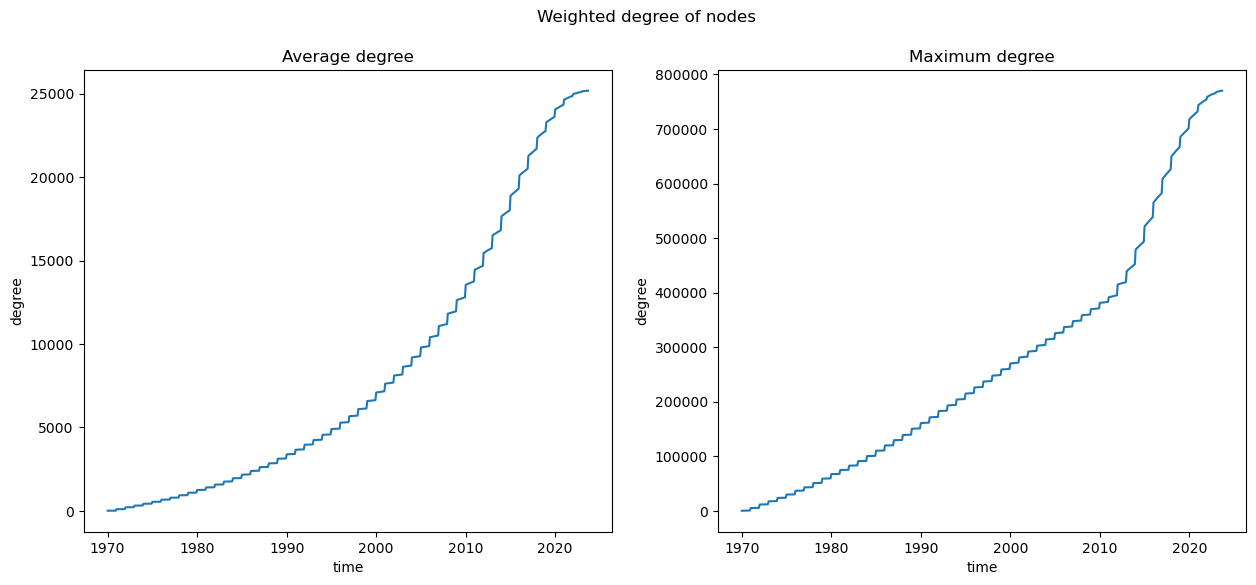

In [36]:
arr_avg_degree = arr_adj.sum(axis = 2).mean(axis = 1)
arr_max_degree = arr_adj.sum(axis = 2).max(axis = 1)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

ax = axes[0]
ax.plot(df_evolution.index, arr_avg_degree)
ax.set_xlabel('time')
ax.set_ylabel('degree')
ax.set_title('Average degree')

ax = axes[1]
ax.plot(df_evolution.index, arr_max_degree)
ax.set_xlabel('time')
ax.set_ylabel('degree')
ax.set_title('Maximum degree')

fig.suptitle('Weighted degree of nodes')
plt.show()

# Rete al tempo finale

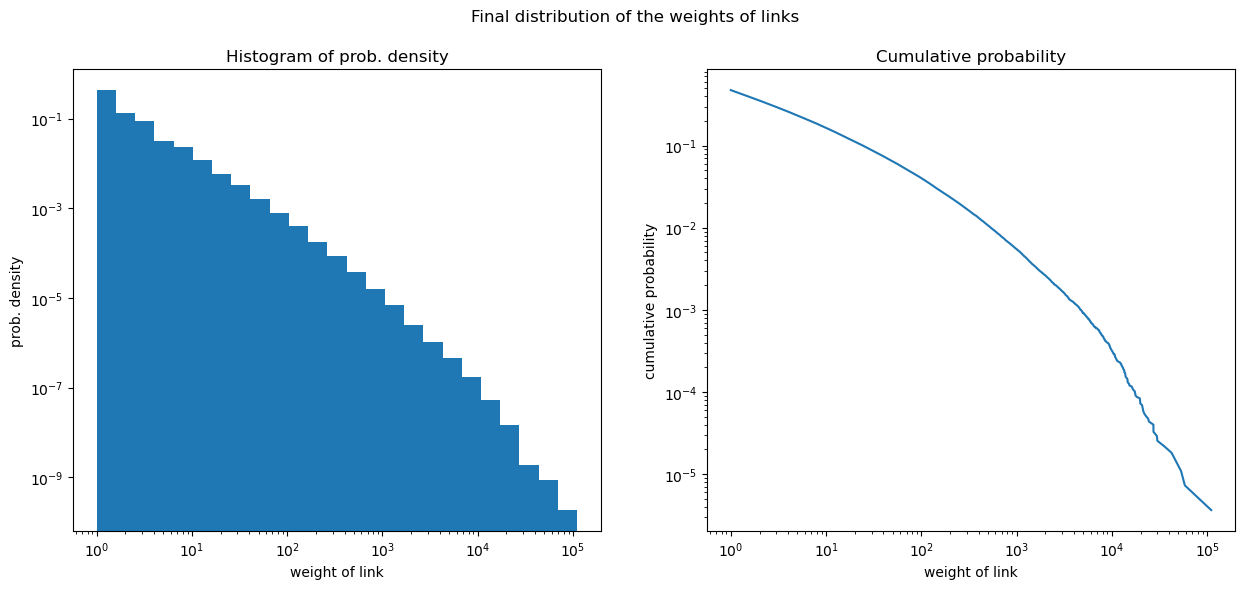

In [37]:
arr_final_weights = np.array([arr_adj[-1, i, j] for i in range(n_sectors) for j in range(i + 1, n_sectors)])
n_bins = 5 * math.floor(np.log10(arr_final_weights.max()))
bins = np.logspace(0, np.log10(arr_final_weights.max()), n_bins + 1)

df_stats = pd.DataFrame(clc.Counter(arr_final_weights).items(), columns = ['weight', 'population']).sort_values('weight')
df_stats['cumul_population'] = df_stats.loc[::-1, 'population'].cumsum()[::-1]
df_stats['cumul_probability'] = df_stats['cumul_population'] / df_stats['population'].sum()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

ax = axes[0]
ax.hist(arr_final_weights, bins = bins, density = True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('weight of link')
ax.set_ylabel('prob. density')
ax.set_title('Histogram of prob. density')

ax = axes[1]
ax.plot(df_stats['weight'][1:], df_stats['cumul_probability'][1:])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('weight of link')
ax.set_ylabel('cumulative probability')
ax.set_title('Cumulative probability')

fig.suptitle('Final distribution of the weights of links')
plt.show()

#display(df_stats)

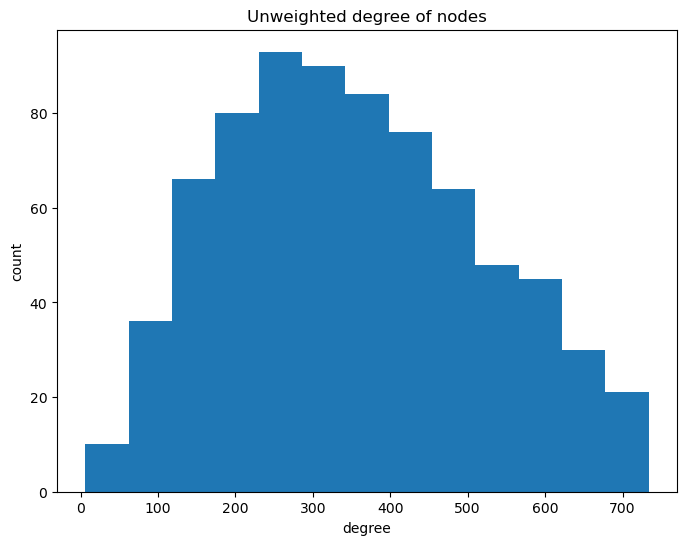

In [46]:
arr_degree_unweighted = arr_adj[-1].astype(bool).sum(axis = 1)

fig, ax = plt.subplots(figsize = (8, 6))
ax.hist(arr_degree_unweighted, bins = 'doane')
ax.set_xlabel('degree')
ax.set_ylabel('count')
ax.set_title('Unweighted degree of nodes')
plt.show()

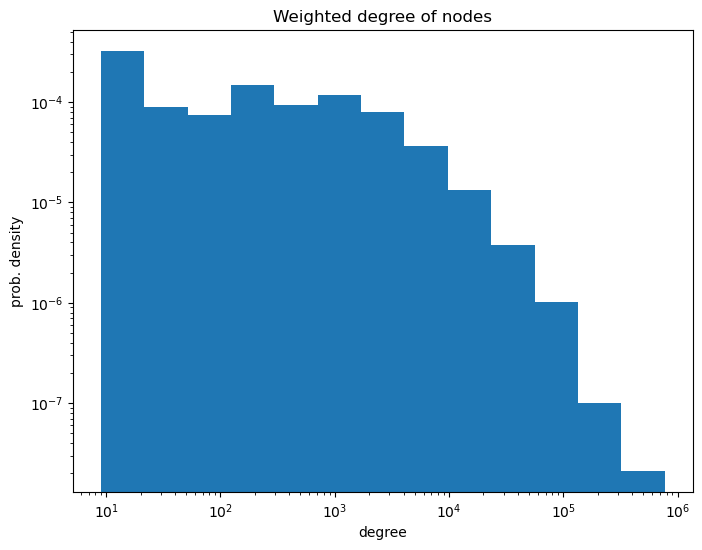

In [49]:
arr_degree_weighted = arr_adj[-1].sum(axis = 1)
n_bins = math.floor(1/2 * pow(arr_degree_weighted.shape[0], 1/2))
bins = np.logspace(np.log10(arr_degree_weighted.min()), np.log10(arr_degree_weighted.max()), n_bins + 1)

fig, ax = plt.subplots(figsize = (8, 6))
ax.hist(arr_degree_weighted, bins = bins, density = True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('degree')
ax.set_ylabel('prob. density')
ax.set_title('Weighted degree of nodes')
plt.show()

# Innovazione

In [50]:
%%time

arr_adj_mod = arr_adj.copy()
for j in range(n_sectors):
    for i in range(j, n_sectors):
        arr_adj_mod[:, i, j] = 0
df_time_start = (
    pd.DataFrame(np.argwhere(arr_adj_mod > 0), columns = ['time_link', 'sector_1', 'sector_2'])
    .groupby(['sector_1', 'sector_2'])[['time_link']].apply(min)
    .reset_index()
)
del(arr_adj_mod)

ser_sector_start = pd.DataFrame(np.argwhere(arr_nodes > 0), columns = ['time', 'sector']).groupby('sector')['time'].apply(min)
df_time_start['time_sector_1'] = ser_sector_start[df_time_start['sector_1']].values
df_time_start['time_sector_2'] = ser_sector_start[df_time_start['sector_2']].values
df_time_start['time_sector_max'] = df_time_start[['time_sector_1', 'time_sector_2']].max(axis = 1)
df_time_start['time_diff'] = df_time_start['time_link'] - df_time_start['time_sector_max']

df_time_start

CPU times: user 12.8 s, sys: 1.98 s, total: 14.8 s
Wall time: 15.4 s


,sector_1,sector_2,time_link,time_sector_1,time_sector_2,time_sector_max,time_diff
0,0,1,36,10,7,10,26
1,0,5,495,10,48,48,447
2,0,9,568,10,4,10,558
3,0,10,156,10,12,12,144
4,0,12,12,10,1,10,2
...,...,...,...,...,...,...,...
131220,738,740,444,12,11,12,432
131221,738,741,584,12,12,12,572
131222,739,740,373,12,11,12,361
131223,740,741,372,11,12,12,360


In [54]:
df_time_start['time_diff'].max()

640

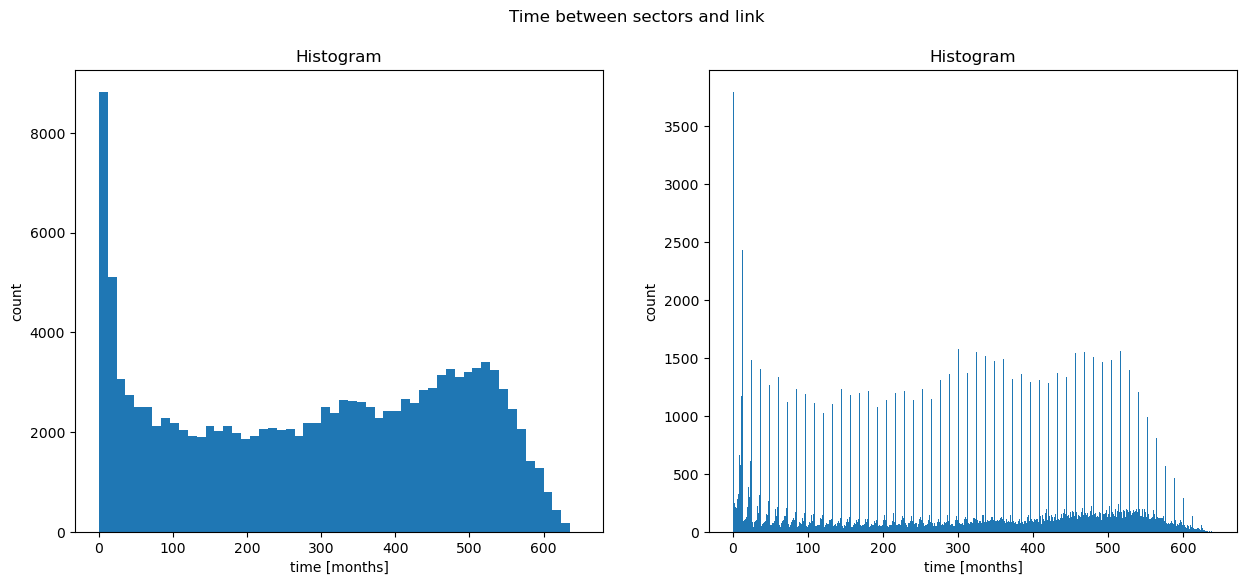

In [56]:
time_max = math.ceil(df_time_start['time_diff'].max() / 12) * 12 + 1
bins = list(range(0, time_max, 12))

df_stats = pd.DataFrame(df_time_start['time_diff'].value_counts().sort_index())
df_stats['cumul_count'] = df_stats.loc[::-1, 'count'].cumsum()[::-1]
df_stats['cumul_probability'] = df_stats['cumul_count'] / df_stats['count'].sum()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))

ax = axes[0]
ax.hist(df_time_start['time_diff'], bins = bins)
ax.set_xlabel('time [months]')
ax.set_ylabel('count')
ax.set_title('Histogram')

ax = axes[1]

ax.hist(df_time_start['time_diff'], bins = df_time_start['time_diff'].max())
ax.set_xlabel('time [months]')
ax.set_ylabel('count')
ax.set_title('Histogram')

fig.suptitle('Time between sectors and link')
plt.show()

# Ecosistema

In [152]:
country = 'ITA'
city = 'Milan'

arr_sectors_sel = (
    df_organizations.loc[
        (df_organizations['country_code'] == country) & (df_organizations['city'] == city), 'sectors'
    ].explode().unique().astype(int)
)
arr_sectors_sel.sort()
arr_adj_sel = arr_adj[-1, *np.ix_(arr_sectors_sel, arr_sectors_sel)]

print('GLOBAL NETWORK')
print(f'N. of sectors: {arr_adj.shape[0]}')
print(f'Average degree (unweighted): {arr_adj[-1].astype(bool).sum(axis = 1).mean() : .2f}')
print(f'Max degree (unweighted): {arr_adj[-1].astype(bool).sum(axis = 1).max()}')
print(f'Average degree (weighted): {arr_adj[-1].sum(axis = 1).mean() : .2f}')
print(f'Max degree (weighted): {arr_adj[-1].sum(axis = 1).max()}')

print('\nSELECTED ECOSYSTEM')
print(f'N. of sectors: {arr_adj_sel.shape[0]}')
print(f'Average degree (unweighted): {arr_adj_sel.astype(bool).sum(axis = 1).mean() : .2f}')
print(f'Max degree (unweighted): {arr_adj_sel.astype(bool).sum(axis = 1).max()}')
print(f'Average degree (weighted): {arr_adj_sel.sum(axis = 1).mean() : .2f}')
print(f'Max degree (weighted): {arr_adj_sel.sum(axis = 1).max()}')

GLOBAL NETWORK
N. of sectors: 645
Average degree (unweighted):  353.23
Max degree (unweighted): 734
Average degree (weighted):  25177.78
Max degree (weighted): 770211

SELECTED ECOSYSTEM
N. of sectors: 605
Average degree (unweighted):  354.81
Max degree (unweighted): 603
Average degree (weighted):  30215.96
Max degree (weighted): 760315
